Import necessary libraries:

In [27]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

## Regression decision tree

First, we use the built-in implementation of the decision tree in Python. 

In [29]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from graphviz import Source
import pydot

As a benchmark we use ```boston``` dataset from the ```scikit-learn``` package.

In [30]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

X = housing.data
y = housing.target/50. # just for convenience
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

Fit the model (notice that we use parameter ```max_depth``` to restrict the tree size):

In [31]:
clf = DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X_train, y_train)

And visualize the resulted tree:

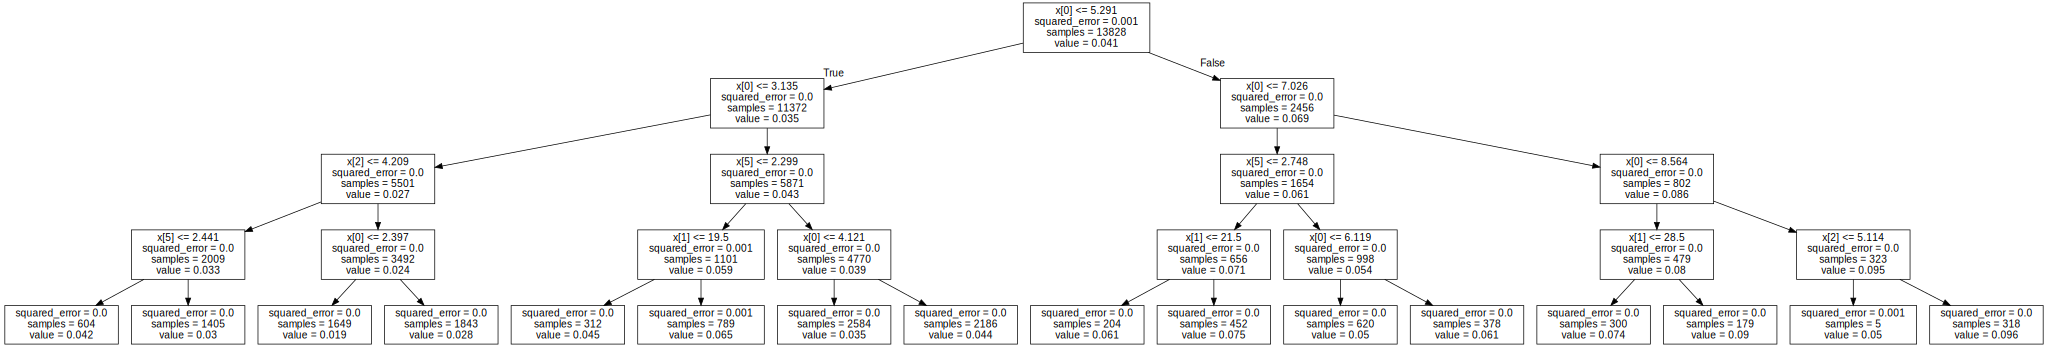

In [32]:
# produces dot file
export_graphviz(clf, out_file='regression_tree_scikit.dot')
dot = open('regression_tree_scikit.dot').read()
dot = dot.replace('node [shape=box] ;', 
     'node [shape=box] ;\ngraph [size="10.3,10.3!"];')
dot = Source(dot)
dot

The predictions can be obtained as follows:

In [33]:
y_pred = clf.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.00023317023852823592


We want to show a simple implementation of decision tree algorithm from scratch. There are different possibilities to implement the decision tree in Python. We will create two classes for node and tree, accordingly. ```Node``` class contains the description of each node and pointer to father and daughter nodes, and ```RegressionTree``` class contains all nodes and functions for splitting and predicton. We have added the function that saves tree structure in the dot file.

In [34]:
class Node():
    def __init__(self, id, samples, prediction, 
                 error, father_node=None):
        if father_node is None: # the node is a root node
            self.depth = 0
        else:
            self.depth = father_node.depth + 1
        self.father_node = father_node
        self.id = id
        self.samples = np.array(samples)
        self.prediction = prediction
        self.error = error
        self.j = None
        self.t = None

class RegressionTree():
    def __init__(self, X, y, max_depth=5, min_samples_leaf = 1):
        self.X = X
        self.y = y
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.nodes = []
        mu, err = self.error(y)
        self.nodes.append(Node(0, [x for x in range(X.shape[0])], 
                               mu, err))
        self.nodes_to_split = [0]

    def error(self, y):
        p = np.mean(y)
        return p, np.mean(np.power(y-p, 2))
        
    def split_next_node(self):
        if len(self.nodes_to_split) == 0:
            return
        node = self.nodes[self.nodes_to_split[0]]
        del self.nodes_to_split[0]
        if (node.depth >= self.max_depth or 
            len(node.samples)<=2*self.min_samples_leaf-1):
            node.left = None
            node.right = None
            return
        best_j = -999
        best_t = -999
        best_se1 = node.error*len(node.samples)
        best_se2 = node.error*len(node.samples)
        best_mu1 = -999
        best_mu2 = -999
        for j in range(self.X.shape[1]):
            Xj = self.X[node.samples,j]
            Xj_min = np.min(Xj)
            Xj_max = np.max(Xj)
            for t in np.linspace(Xj_min, Xj_max, 300):
                y_left = self.y[node.samples][Xj<t]
                y_right = self.y[node.samples][Xj>=t]
                if (len(y_left)<self.min_samples_leaf or 
                    len(y_right)<self.min_samples_leaf):
                    continue
                mu1, mse1 = self.error(y_left)
                mu2, mse2 = self.error(y_right)
                se1 = mse1*len(y_left)
                se2 = mse2*len(y_right)
                if (se1 + se2) < (best_se1 + best_se2):
                    best_j = j
                    best_t = t
                    samples_left = node.samples[Xj<t]
                    samples_right = node.samples[Xj>=t]
                    best_mu1 = mu1
                    best_mu2 = mu2
                    best_se1 = se1
                    best_se2 = se2
                    best_mse1 = mse1
                    best_mse2 = mse2
        if best_j == -999:
            node.left = None
            node.right = None
        else:
            node.left = Node(len(self.nodes), samples_left, 
                             best_mu1, best_mse1, node)
            node.right = Node(len(self.nodes)+1, samples_right, 
                              best_mu2, best_mse2, node)
            node.j = best_j
            node.t = best_t
            self.nodes.append(node.left)
            self.nodes.append(node.right)
            self.nodes_to_split.append(len(self.nodes)-2)
            self.nodes_to_split.append(len(self.nodes)-1)
    
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            node = self.nodes[0]
            while True:
                if node.j is None:
                    preds.append(node.prediction)
                    break
                if X[i, node.j] < node.t:
                    node = node.left
                else:
                    node = node.right
        return preds
    
    def save_tree_to_dot(self, filename):
        def get_edge(x):
            if x.j is None:
                label = 'mse = ' + str(np.round(x.error,3)) +\
                        '\n samples = ' + str(len(x.samples)) +\
                        '\n value = ' + str(np.round(x.prediction,3))
            else:
                label = 'X[' + str(x.j) + '] < ' + str(np.round(x.t)) +\
                        '\n mse = ' + str(np.round(x.error,3)) +\
                        '\n samples = ' + str(len(x.samples)) +\
                        '\n value = ' + str(np.round(x.prediction,3))
            if x.father_node is None:
                return str(x.id) + ' [ label="' + label + '"] ;\n'
            else:
                return str(x.id) + ' [ label="' + label + '"] ;\n' +\
                                 str(x.father_node.id) +\
                                 ' -> ' + str(x.id) + ' ;\n' 

        f = open(filename, 'w')
        add_line = 'digraph Tree {\n node [shape = box] ;\n graph [size="9.7,8.3!"];\n'
        f.write(add_line)
        for x in self.nodes:
            f.write(get_edge(x))
        f.write('}')
        f.close()
        

In [35]:
tree = RegressionTree(X_train, y_train, 
                      max_depth=4, min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
tree.save_tree_to_dot('regression_tree_manual.dot')

Check the error on the test set:

In [36]:
mean_squared_error(y_test, tree.predict(X_test))

0.00024243986841553856

We can also draw the tree from the dot file (remember that we saved tree in the dot file already):

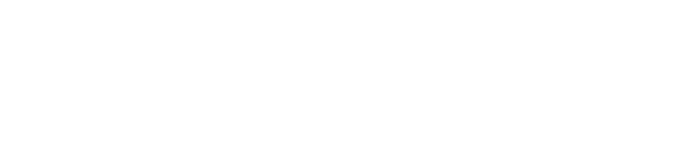

In [37]:
dot = Source(open('regression_tree_manual.dot').read())
dot

## Classification decision tree

As a benchmark we use ```make_moons``` data:

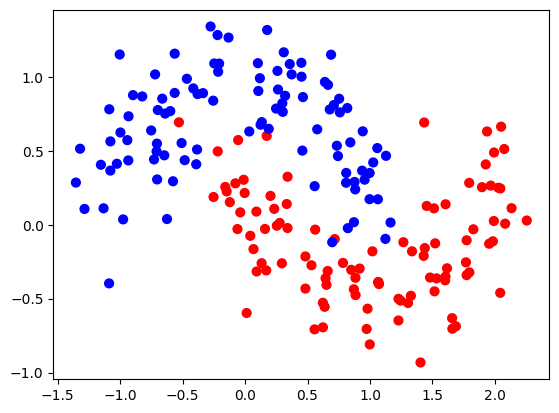

In [38]:
np.random.seed(0)
X, y = ds.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

The following function ```plot_decision_boundary()``` visualizes the result of our classifiction:

In [39]:
def plot_decision_boundary(model, xmin=-0.1, xmax=1.1, 
                           ymin=-0.1, ymax=1.1):
    fig = plt.figure(figsize=(6,6))
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 500),
                         np.linspace(ymin, ymax, 500))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, 
               interpolation='bilinear', 
               extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

The ```scikit-learn``` has its own implementation of classification decision trees:

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
clf = DecisionTreeClassifier(max_depth=10, 
                             min_samples_leaf=4)
clf = clf.fit(X_train, y_train)

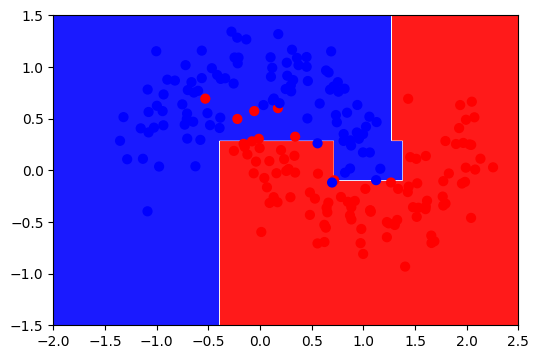

In [42]:
plot_decision_boundary(clf, xmin=-2.0, xmax=2.5, 
                       ymin=-1.5, ymax=1.5)

The main difference between regression and classification decision trees is the metrics used to estimate the quality of split. In regression decision tree we used a mean squared error, in classification decision tree we will use Gini index, cross-entropy or misclassification rate:

In [43]:
class ClassificationTree():
    def __init__(self, X, y, error_type='gini', 
                 max_depth=5, min_samples_leaf = 1):
        self.X = X
        self.y = y
        self.error_type = error_type        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.nodes = []
        mu, err = self.error(y)
        self.nodes.append(Node(0, [x for x in range(X.shape[0])], 
                               mu, err))
        self.nodes_to_split = [0]
    
    def error(self, y):
        p = np.mean(y)
        if self.error_type == 'entropy':
            p = np.clip(p, 0.01, 0.99)
            return p, -1.0*p*np.log(p)-(1-p)*np.log(1-p)
        elif self.error_type == 'gini':
            return p, 2.0*p*(1.0-p)
        elif self.error_type == 'misclass':
            return p, min(p, 1-p)
    
    def split_next_node(self):
        if len(self.nodes_to_split) == 0:
            return
        node = self.nodes[self.nodes_to_split[0]]
        del self.nodes_to_split[0]
        if (node.depth >= self.max_depth 
            or len(node.samples)<=2*self.min_samples_leaf-1 
            or node.error == 0.0):
            node.left = None
            node.right = None
            return
        best_j = -999
        best_t = -999
        best_weighted_err1 = node.error*len(node.samples)
        best_weighted_err2 = node.error*len(node.samples)
        best_mu1 = -999
        best_mu2 = -999
        for j in range(self.X.shape[1]):
            Xj = self.X[node.samples,j]
            Xj_min = np.min(Xj)
            Xj_max = np.max(Xj)
            for t in np.linspace(Xj_min, Xj_max, 300):
                y_left = self.y[node.samples][Xj<t]
                y_right = self.y[node.samples][Xj>=t]
                if (len(y_left)<self.min_samples_leaf 
                    or len(y_right)<self.min_samples_leaf):
                    continue
                mu1, err1 = self.error(y_left)
                mu2, err2 = self.error(y_right)
                weighted_err1 = err1*len(y_left)
                weighted_err2 = err2*len(y_right)
                if (weighted_err1 + weighted_err2 < 
                    best_weighted_err1 + best_weighted_err2):
                    best_j = j
                    best_t = t
                    samples_left = node.samples[Xj<t]
                    samples_right = node.samples[Xj>=t]
                    best_mu1 = mu1
                    best_mu2 = mu2
                    best_err1 = err1
                    best_err2 = err2
                    best_weighted_err1 = weighted_err1
                    best_weighted_err2 = weighted_err2
        if best_j == -999:
            node.left = None
            node.right = None
        else:
            node.left = Node(len(self.nodes), samples_left, 
                             best_mu1, best_err1, node)
            node.right = Node(len(self.nodes)+1, samples_right, 
                              best_mu2, best_err2, node)
            node.j = best_j
            node.t = best_t
            self.nodes.append(node.left)
            self.nodes.append(node.right)
            self.nodes_to_split.append(len(self.nodes)-2)
            self.nodes_to_split.append(len(self.nodes)-1)
    
    def predict(self, X, probability = False):
        preds = []
        for i in range(X.shape[0]):
            node = self.nodes[0]
            while True:
                if node.j is None:
                    preds.append(node.prediction)
                    break
                if X[i, node.j] < node.t:
                    node = node.left
                else:
                    node = node.right
        if probability == False:
            preds = np.round(preds)
        return np.array(preds)

    def save_tree_to_dot(self, filename):
        def get_edge(x):
            if x.j is None:
                label = 'error = ' + str(np.round(x.error,3)) +\
                        '\n samples = ' + str(len(x.samples)) +\
                        '\n prob = ' + str(np.round(x.prediction,3))
                if x.prediction > 0.5:
                    color = 'red'
                else:
                    color = 'blue'
            else:
                label = 'X['+str(x.j)+'] < '+str(np.round(x.t,3))+\
                        '\n error = '+str(np.round(x.error,3))+\
                        '\n samples = '+str(len(x.samples))+\
                        '\n prob = '+str(np.round(x.prediction,3))
                color = 'white'
            if x.father_node is None:
                return str(x.id)+' [ style=filled fillcolor='+color+\
                       ' label="'+label+'"] ;\n'
            else:
                return str(x.id)+' [ style=filled fillcolor='+color+\
                       ' label="'+label+'"] ;\n'+\
                       str(x.father_node.id)+' -> '+str(x.id)+' ;\n' 

        f = open(filename, 'w')
        f.write('digraph Tree {\n node [shape = box] ;\n')
        for x in tree.nodes:
            f.write(get_edge(x))
        f.write('}')
        f.close()

In [44]:
tree = ClassificationTree(X_train, y_train, 
                          error_type='gini', 
                          max_depth=10, min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
tree.save_tree_to_dot('classification_tree_manual.dot')

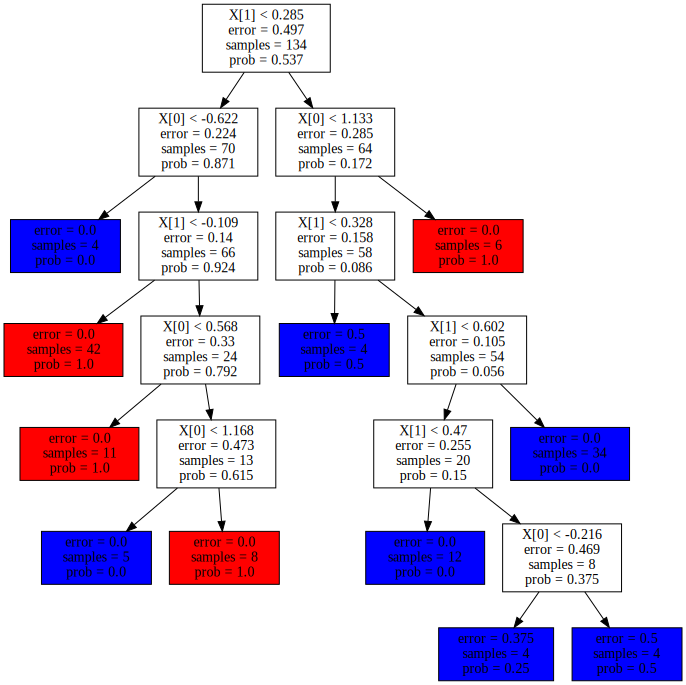

In [45]:
dot = Source(open('classification_tree_manual.dot').read())
dot

Compare the desicion boundaries for different error types:

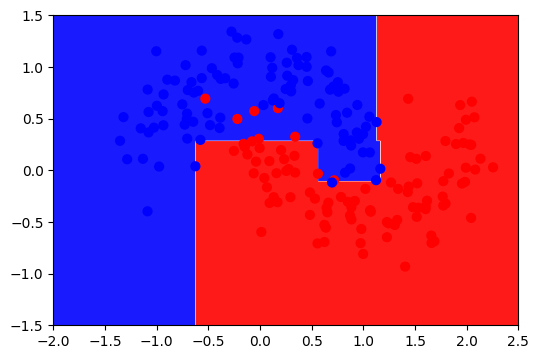

In [46]:
tree = ClassificationTree(X_train, y_train, 
                          error_type='gini', max_depth=10, 
                          min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
plot_decision_boundary(tree, 
                       xmin=-2.0, xmax=2.5, 
                       ymin=-1.5, ymax=1.5)

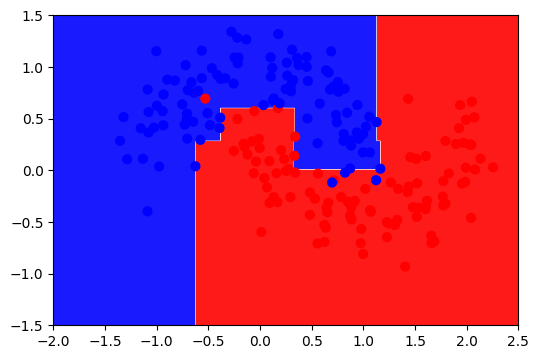

In [47]:
tree = ClassificationTree(X_train, y_train, 
                          error_type='entropy', max_depth=10, 
                          min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
plot_decision_boundary(tree, 
                       xmin=-2.0, xmax=2.5, 
                       ymin=-1.5, ymax=1.5)

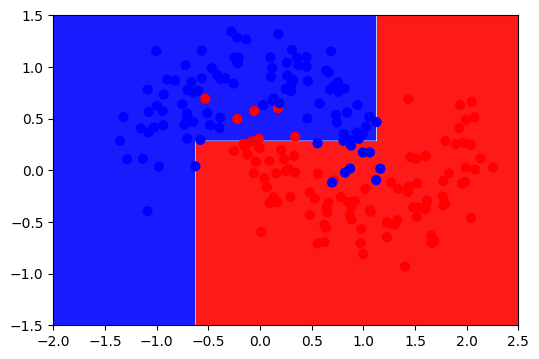

In [48]:
tree = ClassificationTree(X_train, y_train, 
                          error_type='misclass', max_depth=10, 
                          min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
plot_decision_boundary(tree, 
                       xmin=-2.0, xmax=2.5, 
                       ymin=-1.5, ymax=1.5)

# Gradient tree boosting (XGBOOST)

As a benchmark we use the ```boston``` data from the ```scikit-learn``` package.

In [50]:
X = housing.data
y = housing.target/50.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [52]:
print('Number of training examples: ' + str(X.shape[0]))
print('Number of features: ' + str(X.shape[1]))

Number of training examples: 20640
Number of features: 8


Now we train the gradient trees boosting model implemented in the package ```xgboost```:

In [54]:
import xgboost as xgb

param = {}
param['objective'] = 'reg:linear'
param['eta'] = 0.03
param['max_depth'] = 10
param['eval_metric'] = 'rmse'
param['silent'] = 1
param['nthread'] = 8
param['gamma'] = 1.0
param['lambda'] = 0.0
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 1.0
num_round = 1000
param['seed'] = 2657
plst = list(param.items())

xgmat_train = xgb.DMatrix(X_train, label=y_train, 
                          missing = -999.0)
bst = xgb.train( plst, xgmat_train, num_round );
xgmat_test = xgb.DMatrix(X_test, missing = -999.0)
y_pred = bst.predict( xgmat_test )
print(mean_squared_error(y_test, y_pred))

/home/ebezerra/anaconda3/envs/gcc1734/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:18:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/ebezerra/anaconda3/envs/gcc1734/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:18:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.0004283015118457245


# Gradient tree boosting (implementation from scratch)

We implement gradient tree boosting using ```DecisionTreeRegressor``` class from the ```scikit-learn```. Notice that we did not use a lot of tricks (like shrinkage, regularization and so on).

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
def dLdf(X, y, f0, f):
    if len(f) > 0:
        ypred = np.sum(np.array([fj.predict(X) for fj in f]).T, 
                       axis=1) + f0
    else:
        ypred = np.ones_like(y) * f0
    return y - ypred

def gradient_boosting_trees(X, y, ntrees=100, max_depth=3):
    f0 = np.mean(y)
    nsamples = X.shape[0]
    f = []
    for k in range(ntrees):
        # define the working target
        r = dLdf(X, y, f0, f)
        clf = DecisionTreeRegressor(max_depth=max_depth)
        clf.fit(X, r)
        f.append(clf)
    return f0, f

In [57]:
f0, f = gradient_boosting_trees(X_train, y_train, 
                                ntrees=100, max_depth=2)

In [59]:
ypred = np.sum(np.array([fj.predict(X_test) for fj in f]).T,
               axis=1) + f0
mean_squared_error(y_test, ypred)

0.0001087317954718721

Compared to the single decision tree, the accuracy is better:

In [61]:
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
mean_squared_error(y_test, ypred)

0.0002143651538961619